In [506]:
# load arrs, pgv2/3/4
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np

np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def freeze_array(BA, P):
    P2 = np.zeros_like(P)
    P2[:, 0] = P[:, 0]
    for t in range(1, P.shape[1]):
        if BA[t] == 0:
            P2[:, t] = P[:, t]  # Update to current value in P
        else:
            P2[:, t] = P2[:, t - 1]  # Hold previous value
    return P2

def compare_arrays(pos_arr, pos_plan_arr):
    return np.where(pos_arr == pos_plan_arr, 0, 1)

file_ = 'outer_loop_pg_new_v4f_17_10-182641.pkl' 
# 'outer_loop_pg_new_v4f_15_10-204705.pkl' #'outer_loop_pg_new_v4f_15_10-112328.pkl' #'outer_loop_pg_new_v4f_13_10-084101.pkl' # 'outer_loop_pg_new_v4f_14_10-015536.pkl' # 'outer_loop_pg_new_v4f_13_10-084101.pkl' # 'outer_loop_pg_new_v4f_12_10-173828.pkl' #'outer_loop_pg_new_v4f_13_10-081756.pkl' # 'outer_loop_pg_new_v4f_12_10-080400.pkl' # 'outer_loop_pg_new_v4f_12_10-175620.pkl' #'outer_loop_pg_new_v4f_12_10-173828.pkl' #'outer_loop_pg_new_v4f_12_10-151505.pkl' # 'outer_loop_pg_new_v4f_12_10-084905.pkl' # 'outer_loop_pg_new_v4f_12_10-080400.pkl' # 'outer_loop_pg_new_v4_26_09-022146.pkl' # 'outer_loop_pg_new_v4_24_09-201550.pkl' # 'outer_loop_pg_new_v4_18_09-093520.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'outer_loop_pg_new_v4_ppo_new__19_09-172733.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'sc_project/test_data/outer_loop_pg_new_v4_ppo_new__19_09-172733.pkl' # 'outer_loop_pg_new_v4_17_09-200259.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'outer_loop_pg_new_v3_c__15_09-203653.pkl'
other = load_data(file_)
# (r_arr,rt_arr,sample_arr,pos_plan_arr,pos_arr,dot_arr) = other # (r_arr,rt_arr,sample_arr,pos_plan_arr,pos_arr,dot_arr) (r_arr,rt_arr,pos_arr,dot_arr)
(r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr,policy_arr) = other
# print('r_arr.shape=',r_arr.shape,'rt_arr.shape=',rt_arr.shape,'pos_plan_arr.shape=',pos_plan_arr.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'sample_arr.shape=',sample_arr.shape)
print('r_arr.shape=',r_arr.shape,'rp_arr.shape=',rp_arr.shape,'sample_arr.shape=',sample_arr.shape,'mask_arr.shape=',mask_arr.shape,'pos_plan_arr.shape=',pos_plan_arr.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'policy_arr.shape=',policy_arr[0].shape)
print('r_tot=',np.mean(np.sum(r_arr,axis=1)))
print('mask_arr=',np.mean(mask_arr))

r_arr.shape= (1000, 60) rp_arr.shape= (1000, 60) sample_arr.shape= (1000, 60) mask_arr.shape= (1000, 60) pos_plan_arr.shape= (1000, 61, 2) pos_arr.shape= (1000, 61, 2) dot_arr.shape= (1000, 61, 2) policy_arr.shape= (1000, 60, 81)
r_tot= 4.654378
mask_arr= 0.21646667


In [399]:
# sort arrs, pgv1/2/3/4
tot_reward = jnp.sum(r_arr, axis=1)
r_tot_desc = jnp.argsort(tot_reward)[::-1]
r_tot_asc = jnp.argsort(tot_reward) #[::-1]
tot_plan = jnp.sum(sample_arr, axis=1)
plan_desc = jnp.argsort(tot_plan)[::-1]
# tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
# loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
# loss_v_desc = jnp.argsort(tot_loss_v)[::-1]
# tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
# loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('r_tot_desc=',r_tot_desc[:10])
print('r_tot_asc=',r_tot_asc[:10])
print('plan_desc=',plan_desc[:10])
# print('loss_v_asc=',loss_v_asc[:10])
# print('loss_v_desc=',loss_v_desc[:10])
# print('loss_d_asc=',loss_d_asc[:10])

r_tot_desc= [ 52 909 526 173 410 818 876 185 609 922]
r_tot_asc= [372 234 953 983 178 231 636 224 785 128]
plan_desc= [958 158 990 906 888 824 588 489 365 893]


In [423]:
# binned sort
%matplotlib inline

# Calculate dot speeds
dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=5)  # Assuming 4 bins
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Loop through speed bins
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_indices = np.where(mask)[0]  # Keep track of original indices
    masked_decisions = sample_arr[mask]
    masked_rewards = r_arr[mask]
    
    total_rewards = np.sum(masked_rewards, axis=1)
    planning_rates = np.mean(masked_decisions, axis=1)
    product_scores = total_rewards * planning_rates

    # Get the sorted indices in descending order
    reward_indices = np.argsort(total_rewards)[::-1]
    planning_indices = np.argsort(planning_rates)[::-1]
    product_indices = np.argsort(product_scores)[::-1]

    # Top 5 indices for rewards and planning rates
    top_reward_indices = reward_indices[:5]
    top_planning_indices = planning_indices[:50]
    top_product_indices = product_indices[:10]
    
    # Map back to original indices
    original_top_reward_indices = masked_indices[top_reward_indices]
    original_top_planning_indices = masked_indices[top_planning_indices]
    original_top_product_indices = masked_indices[top_product_indices]
    
    # Print the results
    print("top rewards for speed bin", i+1)
    for idx, original_idx in enumerate(original_top_reward_indices):
        print(f" Index: {original_idx}, Reward: {total_rewards[top_reward_indices[idx]]:.2f}")

    print("\n top plan rates for speed bin", i+1)
    for idx, original_idx in enumerate(original_top_planning_indices):
        print(f"Index: {original_idx}, Planning Rate: {planning_rates[top_planning_indices[idx]]:.2f}, reward: {np.sum(r_arr[original_idx,:]):.2f}")

    print("\n top Product Scores for speed bin", i+1)
    for idx, original_idx in enumerate(original_top_product_indices):
        print(f"Index: {original_idx}, Score: {product_scores[top_product_indices[idx]]:.2f}")
    print('----------------------')

print(np.sum(r_arr[996,:]))

/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3539: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


top rewards for speed bin 1
 Index: 414, Reward: 27.79
 Index: 168, Reward: 27.48
 Index: 484, Reward: 26.81
 Index: 41, Reward: 26.22
 Index: 48, Reward: 25.78

 top plan rates for speed bin 1
Index: 982, Planning Rate: 0.15, reward: 7.52
Index: 711, Planning Rate: 0.15, reward: 2.80
Index: 235, Planning Rate: 0.12, reward: 0.82
Index: 216, Planning Rate: 0.12, reward: 0.00
Index: 881, Planning Rate: 0.10, reward: 2.11
Index: 166, Planning Rate: 0.10, reward: 0.29
Index: 939, Planning Rate: 0.08, reward: 0.08
Index: 630, Planning Rate: 0.08, reward: 0.11
Index: 465, Planning Rate: 0.08, reward: 0.05
Index: 868, Planning Rate: 0.07, reward: 0.12
Index: 804, Planning Rate: 0.07, reward: 22.37
Index: 571, Planning Rate: 0.07, reward: 1.03
Index: 250, Planning Rate: 0.07, reward: 4.11
Index: 68, Planning Rate: 0.07, reward: 5.60
Index: 960, Planning Rate: 0.05, reward: 3.98
Index: 872, Planning Rate: 0.05, reward: 1.36
Index: 827, Planning Rate: 0.05, reward: 0.75
Index: 747, Planning Rat

In [ ]:
%matplotlib inline

# Calculate dot speeds
dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=5)  # Assuming 4 bins
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Loop through speed bins
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    print('rshape=',r_arr.shape)
    masked_decisions = sample_arr[mask]
    masked_rewards = r_arr[mask]
    print('rmshape=',masked_rewards.shape)
    
    total_rewards = np.sum(masked_rewards, axis=1)
    print('rtotshape=',total_rewards.shape)
    print('avgr=',np.mean(total_rewards))
    print(total_rewards[:10])
    planning_rates = np.mean(masked_decisions, axis=1)

    # Get the sorted indices in descending order
    reward_indices = np.argsort(total_rewards)[::-1]
    print('rind=',reward_indices[:5],total_rewards[reward_indices[:5]])
    planning_indices = np.argsort(planning_rates)[::-1]

    # Top 5 indices for rewards and planning rates
    top_reward_indices = reward_indices[:5]
    top_planning_indices = planning_indices[:5]
    
    # Plot
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(5), total_rewards[top_reward_indices], tick_label=top_reward_indices)
    plt.title(f"Top 5 Rewards for Dot Speed Bin {i+1}")
    plt.ylabel("Total Reward")
    plt.xlabel("Trial Index")
    
    plt.subplot(1, 2, 2)
    plt.bar(range(5), planning_rates[top_planning_indices], tick_label=top_planning_indices, color='orange')
    plt.title(f"Top 5 Planning Rates for Dot Speed Bin {i+1}")
    plt.ylabel("Planning Rate")
    plt.xlabel("Trial Index")
    
    plt.tight_layout()
    plt.show()

print('r_arr_197=',r_arr[197,:],np.sum(r_arr[197,:]),np.mean(sample_arr[48,:]))

In [ ]:
# full ani pgv2/3 with policy heatmap
# 'un-permute' policy[0] vectors
# plot as timeseries heatmap inside aperture, with colour policy[1] proportion

%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,r_arr,dot_arr,pos_plan_arr,pos_arr,dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,L):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')

    lab = f'Frame={i}, Reward={r_arr[i]:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
    L.get_texts()[0].set_text(lab)

    x_aperture_plan,y_aperture_plan = get_aperture_points(pos_plan_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points_plan.set_offsets(np.c_[mod_(x_aperture_plan), mod_(y_aperture_plan)])
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_act_space_plan,y_act_space_plan = get_aperture_points(pos_plan_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points_plan.set_offsets(np.c_[mod_(x_act_space_plan), mod_(y_act_space_plan)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    
    return [dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,L]

# 449 434 862
k = 128 # 239 # 744 ## 815 ## 273 # 103 # 273 # 743 # 959 # 0,202, 275
interval = 150
APERTURE = (1/2)*np.pi # (3/5)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1 # 1/2
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 2 #3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = pos_arr.shape[1]
MODULES = 7 # 7 # 9 # 17 # 15
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_ACT_PLAN = 15 # 10

r_arr_ = r_arr[k,:]
dot_arr_ = dot_arr[k,:,:] # [STEPS,2]
pos_plan_arr_ = pos_plan_arr[k,:,:] # [STEPS,2]
pos_arr_ = pos_arr[k,:,:] # [STEPS,2]

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent_plan, = ax_ani.plot(mod_(pos_plan_arr_[0, 0]), mod_(pos_plan_arr_[0, 1]), color='lightgrey', marker='+', markersize=12) #, label='agent')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
aperture_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
act_space_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)

L=ax_ani.legend(loc='upper right')

partial_animate = functools.partial(
    animate,
    r_arr=r_arr_,
    dot_arr=dot_arr_, 
    pos_plan_arr=pos_plan_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    agent_plan=agent_plan,
    agent=agent, 
    aperture_points_plan=aperture_points_plan,
    aperture_points=aperture_points,
    act_space_points_plan=act_space_points_plan,
    act_space_points=act_space_points,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

In [494]:
# full ani pgv2/3 wip
%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    # get x/y coords
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    # weighted complex numbers
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    # mean
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    # weighted circular variance for each angle
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    # v_pred_vec = np.clip(v_pred_vec,0,None)
    # v_pred_norm = v_pred_vec/np.sum(v_pred_vec)
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    # mean_magnitude = (np.exp(kappa_x+kappa_y)/((2*np.pi)**2 * scipy.special.i0(kappa_x) * scipy.special.i0(kappa_y)))
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,r_arr,dot_arr,pos_plan_arr,pos_arr,dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,L):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    # dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
        # L.get_texts()[0].set_text(f'Frame={i}, Reward=')
    else:
        aperture_points.set_color('black')

    # x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i],np.pi)### think
    # # x_y_coords,x,y,mean_x_ap,mean_y_ap,sigma_x_ap,sigma_y_ap = circ_mean_var(v_pred_arr[i],np.pi)### think
    # ell_circular.set_center((mod_(mean_x+pos_plan_arr[i, 0]), mod_(mean_y+pos_plan_arr[i, 1])))
    # ell_circular.width = SIGMA_SCALE*sigma_x
    # ell_circular.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_pred.set_center((mean_x, mean_y))
    # ell_circular_v_pred.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_pred.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_t.set_center((mean_x, mean_y))
    # ell_circular_v_t.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_t.height = SIGMA_SCALE*sigma_y
    # if i>0:
    #     in_ell_array[i] = is_point_in_ellipse(mod_(mean_x+pos_plan_arr[i, 0]), mod_(mean_y+pos_plan_arr[i, 1]), mod_(dot_arr[i,0]), mod_(dot_arr[i,1]), SIGMA_SCALE*sigma_x, SIGMA_SCALE*sigma_y)
    #     kappa_x,loc_x,kappa_y,loc_y,mean_magnitude = vonmises_fit(x_y_coords[0,:],x_y_coords[1,:],v_pred_arr[i])
    lab = f'Frame={i}, Reward={r_arr[i]:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
    L.get_texts()[0].set_text(lab)

    # scatters_pred.set_offsets(neuron_locs.T)
    # scatters_pred.set_array(v_pred_arr[i])
    # scatters_pred.set_sizes(15 * np.sqrt(v_pred_arr[i])) # []
    # scatters_pred.set_facecolors('k')

    # scatters_t.set_offsets(neuron_locs.T)
    # scatters_t.set_array(v_t_arr[i])
    # scatters_t.set_sizes(15 * np.sqrt(v_t_arr[i])) # []
    # scatters_t.set_facecolors('k')
    x_aperture_plan,y_aperture_plan = get_aperture_points(pos_plan_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points_plan.set_offsets(np.c_[mod_(x_aperture_plan), mod_(y_aperture_plan)])
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    # x_aperture_centre,y_aperture_centre = get_aperture_points(np.array([0,0]),APERTURE,DENSITY_DEFAULT)
    # aperture_points_v_pred.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    # aperture_points_v_t.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    x_act_space_plan,y_act_space_plan = get_aperture_points(pos_plan_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points_plan.set_offsets(np.c_[mod_(x_act_space_plan), mod_(y_act_space_plan)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])

    # x_plan_space,y_plan_space = get_aperture_points(pos_arr[i],PLAN_SPACE,DENSITY_PLAN_SPACE)
    # plan_space_points.set_offsets(np.c_[mod_(x_plan_space), mod_(y_plan_space)])
    
    return [dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,L]

# 449 434 862
k = 128 # 239 # 744 ## 815 ## 273 # 103 # 273 # 743 # 959 # 0,202, 275
interval = 150
APERTURE = (1/2)*np.pi # (3/5)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1 # 1/2
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 2 #3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = pos_arr.shape[1]
MODULES = 7 # 7 # 9 # 17 # 15
# NEURONS_DISP = np.int32(np.sqrt(v_pred_arr.shape[2])) ##14 # 16 # 15 # 15 # 12 # 6 # ''full'' np.int32(NEURONS_AP*(np.pi//APERTURE))
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_ACT_PLAN = 15 # 10

# neuron_locs = gen_vectors(NEURONS_DISP,jnp.pi) # NEURONS
# v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1)
# v_t_arr_ = v_t_arr[k,:,:]
r_arr_ = r_arr[k,:]
dot_arr_ = dot_arr[k,:,:] # [STEPS,2]
pos_plan_arr_ = pos_plan_arr[k,:,:] # [STEPS,2]
pos_arr_ = pos_arr[k,:,:] # [STEPS,2]
# rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
# dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent_plan, = ax_ani.plot(mod_(pos_plan_arr_[0, 0]), mod_(pos_plan_arr_[0, 1]), color='lightgrey', marker='+', markersize=12) #, label='agent')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')
# dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
aperture_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
act_space_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
# plan_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

# ell_circular = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ell_circular_patch = ax_ani.add_patch(ell_circular)
# text_ani = ax_ani.text(0.5, 0.8, '', transform=ax_ani.transAxes)
# ax_ani.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax_ani.legend(loc='upper right')
L=ax_ani.legend(loc='upper right')

# in_ell_array = np.zeros(STEPS,)

# ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# # update scatter
# scatters_pred = ax_pred.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_pred_arr_[0], 
#     s=15 * np.sqrt(v_pred_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)
# aperture_points_v_pred = ax_pred.scatter([], [], color='black', s=0.5)
# ell_circular_v_pred = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_pred = ax_pred.add_patch(ell_circular_v_pred)
# set_axis_properties(ax_pred, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_pred')

# ax_t = plt.subplot(gs[2, 1], aspect='equal')
# # update scatter
# scatters_t = ax_t.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_t_arr_[0], 
#     s=15 * np.sqrt(v_t_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)  # Assuming activations range from 0 to 1
# aperture_points_v_t = ax_t.scatter([], [], color='black', s=0.5)
# ell_circular_v_t = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_t = ax_t.add_patch(ell_circular_v_t)
# set_axis_properties(ax_t, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_t')

partial_animate = functools.partial(
    animate,
    # v_pred_arr=v_pred_arr_, 
    # v_t_arr=v_t_arr_, 
    r_arr=r_arr_,
    dot_arr=dot_arr_, 
    # dot_hat_arr=dot_hat_arr_,
    pos_plan_arr=pos_plan_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    # dot_hat=dot_hat,
    agent_plan=agent_plan,
    agent=agent, 
    # neuron_locs=neuron_locs, 
    # scatters_pred=scatters_pred, 
    # scatters_t=scatters_t,
    aperture_points_plan=aperture_points_plan,
    aperture_points=aperture_points,
    # aperture_points_v_pred=aperture_points_v_pred,
    # aperture_points_v_t=aperture_points_v_t,
    act_space_points_plan=act_space_points_plan,
    act_space_points=act_space_points,
    # plan_space_points=plan_space_points,
    # ell_circular=ell_circular,
    # ell_circular_v_pred=ell_circular_v_pred,
    # ell_circular_v_t=ell_circular_v_t,
    # in_ell_array=in_ell_array,
    # text_ani=text_ani,
    # ax_ani=ax_ani,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

# print('in_ell_array=',in_ell_array[1:])
# print(r'% in array = ',np.sum(in_ell_array[1:])/(STEPS-1))

/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_38098/147489091.py:86: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_38098/147489091.py:87: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_38098/147489091.py:88: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [391]:
# load arrs, pgv2/3/4
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np

np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def freeze_array(BA, P):
    P2 = np.zeros_like(P)
    P2[:, 0] = P[:, 0]
    for t in range(1, P.shape[1]):
        if BA[t] == 0:
            P2[:, t] = P[:, t]  # Update to current value in P
        else:
            P2[:, t] = P2[:, t - 1]  # Hold previous value
    return P2

def compare_arrays(pos_arr, pos_plan_arr):
    return np.where(pos_arr == pos_plan_arr, 0, 1)


file_ = 'outer_loop_pg_new_v4_26_09-022146.pkl' # 'outer_loop_pg_new_v4f_13_10-081756.pkl' # 'outer_loop_pg_new_v4f_12_10-080400.pkl' # 'outer_loop_pg_new_v4f_12_10-204349.pkl' # 'outer_loop_pg_new_v4f_12_10-084905.pkl' # 'outer_loop_pg_new_v4f_12_10-175620.pkl' #'outer_loop_pg_new_v4f_12_10-173828.pkl' #'outer_loop_pg_new_v4f_12_10-151505.pkl' # 'outer_loop_pg_new_v4f_12_10-084905.pkl' # 'outer_loop_pg_new_v4f_12_10-080400.pkl' # 'outer_loop_pg_new_v4_26_09-022146.pkl' # 'outer_loop_pg_new_v4_24_09-201550.pkl' # 'outer_loop_pg_new_v4_18_09-093520.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'outer_loop_pg_new_v4_ppo_new__19_09-172733.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'sc_project/test_data/outer_loop_pg_new_v4_ppo_new__19_09-172733.pkl' # 'outer_loop_pg_new_v4_17_09-200259.pkl' # 'outer_loop_pg_new_v3_c__18_09-092611.pkl' # 'outer_loop_pg_new_v3_c__15_09-203653.pkl'
# (other,weights_s) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
other = load_data(file_)
(r_arr,rt_arr,sample_arr,pos_plan_arr,pos_arr,dot_arr) = other # (r_arr,rt_arr,sample_arr,pos_plan_arr,pos_arr,dot_arr) (r_arr,rt_arr,pos_arr,dot_arr)
# (r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr) = other
# sample_arr = compare_arrays(pos_arr, pos_plan_arr)
# print('r_arr.shape=',r_arr.shape,'rt_arr.shape=',rt_arr.shape,'pos_plan_arr.shape=',pos_plan_arr.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'sample_arr.shape=',sample_arr.shape)
print('r_arr.shape=',r_arr.shape,'rp_arr.shape=',rp_arr.shape,'pos_plan_arr.shape=',pos_plan_arr.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'sample_arr.shape=',sample_arr.shape)
# pos_plan_arr, pos_arr, dot_arr = pos_plan_arr[:,1:,:], pos_arr[:,1:,:], dot_arr[:,1:,:]

r_arr.shape= (1000, 120) rp_arr.shape= (1000, 60) pos_plan_arr.shape= (1000, 121, 2) pos_arr.shape= (1000, 121, 2) dot_arr.shape= (1000, 121, 2) sample_arr.shape= (1000, 120)


In [ ]:
# shuffle plans
import numpy as np

# Sample data
sample_arr = np.random.randint(0, 2, (1000, 80))

def shuffle_plans(trial):
    # Number of plans in the trial
    num_plans = np.sum(trial)
    
    # Generate shuffled indices
    shuffled_indices = np.random.permutation(len(trial))
    
    # Create a new trial with moves (0s)
    new_trial = np.zeros_like(trial)
    
    # Place plans (1s) at the first 'num_plans' shuffled indices
    new_trial[shuffled_indices[:num_plans]] = 1
    return new_trial

sample_arr_shuffled = np.array([shuffle_plans(trial) for trial in sample_arr])


In [479]:
# reward vs speed for plan/no plan/shuffle
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

sbins = 4
N = dot.shape[0]

# dot speeds
dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=sbins + 1)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

avg_rewards = []
sem_rewards = []

# loop through bins
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_rewards = r_arr[mask]
    total_rewards = np.sum(masked_rewards, axis=1)
    
    avg_reward = np.mean(total_rewards)
    avg_rewards.append(avg_reward)
    
    sem_reward = np.std(total_rewards)/np.sqrt(N)
    sem_rewards.append(sem_reward)

avg_plan_rewards = np.array(avg_rewards)
sem_plan_rewards = np.array(sem_rewards)

print('avg_plan_rewards=',avg_plan_rewards)
print('std_plan_rewards=',sem_plan_rewards)


avg_plan_rewards= [11.508446   2.1043587  1.1658139  1.1110593]
std_plan_rewards= [7.678573   2.6469023  0.86216784 0.7399786 ]


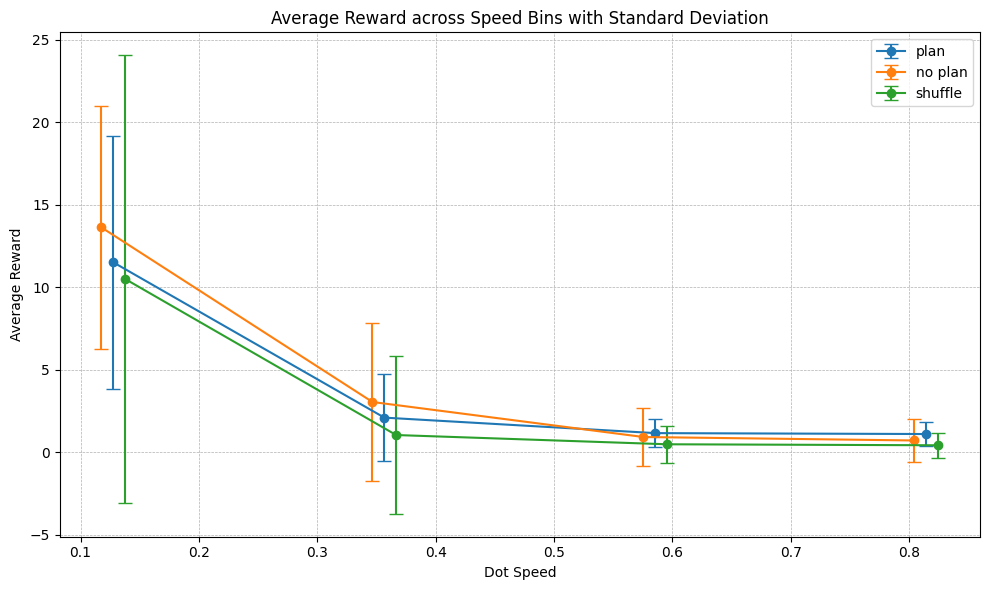

In [491]:
# avg rewards across speed for plan / no plan / shuffled plans - line
plt.figure(figsize=(10, 6))
plt.errorbar(speed_bin_centers, avg_plan_rewards, yerr=1.96*sem_plan_rewards, fmt='o-', capsize=5, label='plan')
plt.errorbar(speed_bin_centers-0.01, avg_noplan_rewards, yerr=sem_noplan_rewards, fmt='o-', capsize=5, label='no plan')
plt.errorbar(speed_bin_centers+0.01, avg_shuffle_rewards, yerr=sem_shuffle_rewards, fmt='o-', capsize=5, label='shuffle')
plt.xlabel("Dot Speed")
plt.ylabel("Average Reward")
plt.title("Average Reward across Speed Bins with Standard Deviation")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

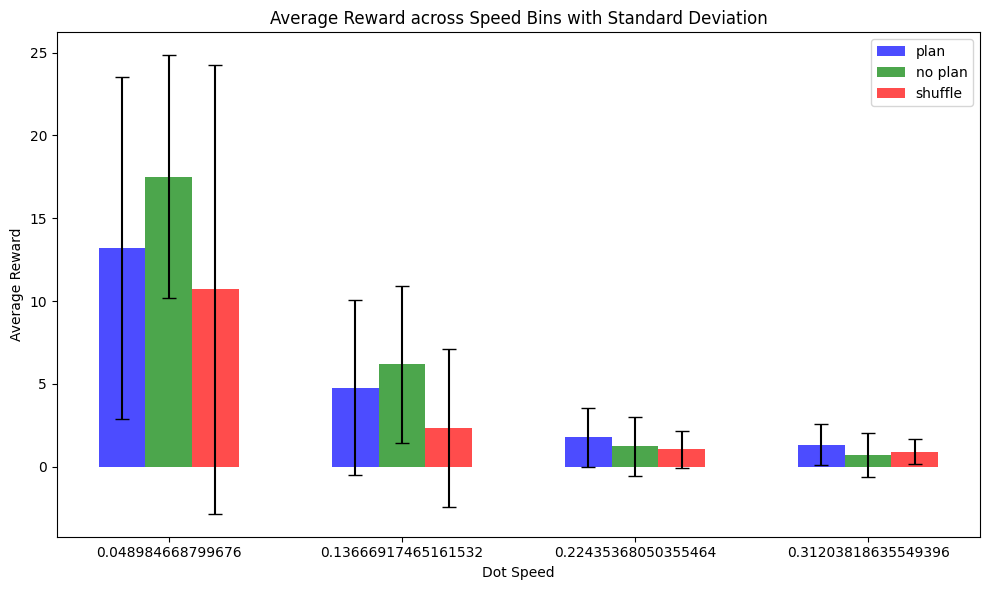

In [310]:
# avg rewards across speed for plan / no plan / shuffled plans - bar

bar_width = 0.2
r1 = np.arange(len(speed_bin_centers))  # Position for first bars
r2 = [x + bar_width for x in r1]       # Position for second set of bars
r3 = [x + bar_width for x in r2]       # Position for third set of bars

plt.figure(figsize=(10, 6))

# Create bars with error bars
plt.bar(r1, avg_plan_rewards, width=bar_width, yerr=1.96*sem_plan_rewards, capsize=5, label='plan', color='blue', alpha=0.7)
plt.bar(r2, avg_noplan_rewards, width=bar_width, yerr=std_noplan_rewards, capsize=5, label='no plan', color='green', alpha=0.7)
plt.bar(r3, avg_shuffle_rewards, width=bar_width, yerr=std_shuffle_rewards, capsize=5, label='shuffle', color='red', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Dot Speed')
plt.ylabel('Average Reward')
plt.title('Average Reward across Speed Bins with Standard Deviation')
plt.xticks([r + bar_width for r in r1], speed_bin_centers)  # Set the x-ticks in the middle of grouped bars
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


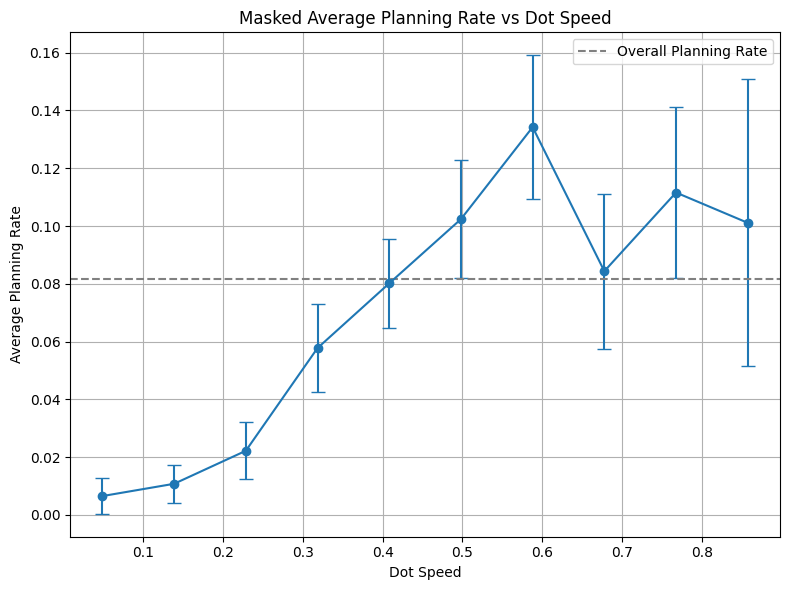

In [517]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

sbins = 10

# Calculate dot speeds
dot_diffs = np.diff(dot_arr, axis=1)  # Shape: [1000, 120, 2]
dot_speeds = np.linalg.norm(dot_diffs, axis=2)  # Shape: [1000, 120]
mean_dot_speeds = np.mean(dot_speeds, axis=1)  # Shape: [1000]

# Calculate planning rates using the mask
masked_samples = np.where(mask_arr == 1, sample_arr, np.nan)  # Replace '0's in mask_arr with nan in sample_arr
planning_rates = np.nanmean(masked_samples, axis=1)  # Compute mean ignoring nan values

# Calculate overall planning rate for the dotted line
overall_rate = np.nanmean(masked_samples)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=sbins +1)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# For each speed bin, calculate mean and sem of planning rates
mean_rates = []
sem_rates = []

for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    rates_in_bin = planning_rates[mask]
    bin_size = np.sum(mask)
    mean_rates.append(np.nanmean(rates_in_bin))
    sem_rates.append(np.nanstd(rates_in_bin) / np.sqrt(bin_size))

# Plotting
plt.figure(figsize=(8, 6))
plt.errorbar(speed_bin_centers, mean_rates, yerr=1.96*np.array(sem_rates), fmt='o-', capsize=5)
plt.axhline(overall_rate, color='gray', linestyle='--', label="Overall Planning Rate")
plt.xlabel('Dot Speed')
plt.ylabel('Average Planning Rate')
plt.title('Masked Average Planning Rate vs Dot Speed')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


bin size  0  =  4
bin size  1  =  60
bin size  2  =  89
bin size  3  =  16


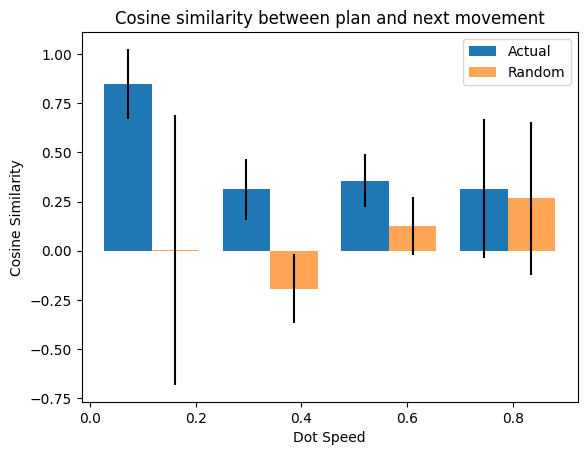

(0.0048547575010608746, -0.1920490310654922, 0.12633118432563742, 0.26623486176416156)


In [530]:
# cos sim between plan / next movement
## use marginal dist of random vectors 

import numpy as np
import matplotlib.pyplot as plt

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

PLAN_SPACE = np.pi/2
MODULES = 9
sbins = 4

x = np.linspace(-PLAN_SPACE,PLAN_SPACE,MODULES)
y = np.linspace(-PLAN_SPACE,PLAN_SPACE,MODULES)[::-1]
xv,yv = np.meshgrid(x,y)
random_directions = np.vstack([xv.flatten(), yv.flatten()])

dot_arr_mod = mod_(dot_arr)
pos_arr_mod = mod_(pos_arr)
pos_plan_arr_mod = mod_(pos_plan_arr)

dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=sbins + 1)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

cos_similarities = []
random_cos_similarities = []

for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_decisions = sample_arr[mask]
    masked_pos = pos_arr_mod[mask]
    masked_pos_plan = pos_plan_arr_mod[mask]
    
    similarities = []
    random_similarities = []
    
    for decision, pos, pos_plan in zip(masked_decisions, masked_pos, masked_pos_plan):
        changes = np.diff(np.concatenate([[0], decision, [0]]))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        
        for start, end in zip(starts, ends):
            plan_traj = pos_plan[end - 1] - pos[start]
            
            if np.linalg.norm(plan_traj) == 0:
                continue
                
            norm_plan_traj = plan_traj / np.linalg.norm(plan_traj)
            
            if end < len(decision) - 1:
                move_dir = pos[end + 1] - pos[end]
                if np.linalg.norm(move_dir) == 0:
                    continue
                
                norm_move_dir = move_dir / np.linalg.norm(move_dir)
                cos_sim = np.dot(norm_plan_traj, norm_move_dir)
                similarities.append(cos_sim)

            random_move_dir = random_directions[:,np.random.choice(MODULES**2)]
            if np.linalg.norm(random_move_dir) == 0:
                continue
            norm_random_move_dir = random_move_dir / np.linalg.norm(random_move_dir)
            random_cos_sim = np.dot(norm_plan_traj, norm_random_move_dir)
            random_similarities.append(random_cos_sim)

    bin_size = len(similarities)
    print('bin size ',i,' = ',bin_size)
    sem_value = np.std(similarities) / np.sqrt(bin_size)

    cos_similarities.append((np.mean(similarities), sem_value))
    
    bin_size_random = len(random_similarities)
    random_sem_value = np.std(random_similarities) / np.sqrt(bin_size_random)
    
    random_cos_similarities.append((np.mean(random_similarities), random_sem_value))

means, sems = zip(*cos_similarities)
random_means, random_sems = zip(*random_cos_similarities)
bar_width = (speed_bins[1] - speed_bins[0]) * 0.4

plt.bar(speed_bin_centers - bar_width/2, means, yerr=1.96*np.array(sems), width=bar_width, label="Actual")
plt.bar(speed_bin_centers + bar_width/2, random_means, yerr=1.96*np.array(random_sems), width=bar_width, label="Random", alpha=0.7)
plt.xlabel('Dot Speed')
plt.ylabel('Cosine Similarity')
plt.title('Cosine similarity between plan and next movement')
plt.legend()
plt.show()

print(random_means)


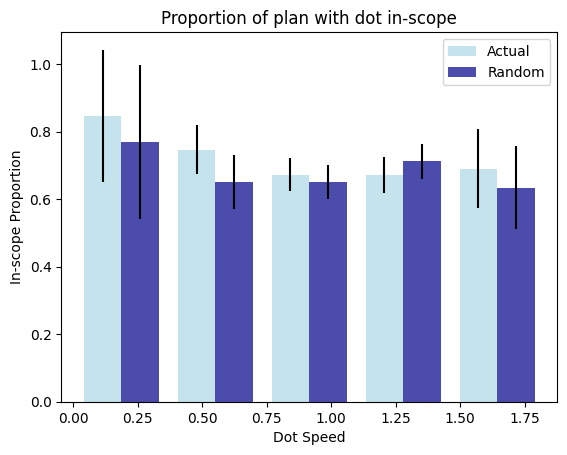

In [535]:
# % plan with in scope, vs random baseline
## use marginal dist of random vectors 

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

# data
pos_arr_mod = mod_(pos_arr)
pos_plan_arr_mod = mod_(pos_plan_arr)
dot_arr_mod = mod_(dot_arr)

AP = np.pi/2
PLAN_SPACE = np.pi/2
MODULES = 9
bins = 5

x = np.linspace(-PLAN_SPACE,PLAN_SPACE,MODULES)
y = np.linspace(-PLAN_SPACE,PLAN_SPACE,MODULES)[::-1]
xv,yv = np.meshgrid(x,y)
random_directions = np.vstack([xv.flatten(), yv.flatten()])

# Calculate dot speeds
dot_diffs = np.diff(dot_arr_mod, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=bins+1)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Result containers
in_scope_ratios = []
random_in_scope_ratios = []

for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_decisions = sample_arr[mask]
    masked_pos = pos_arr_mod[mask]
    masked_pos_plan = pos_plan_arr_mod[mask]
    masked_dot_positions = dot_arr_mod[mask]
    
    ratios = []
    random_ratios = []
    
    for decision, pos, pos_plan, dot_pos in zip(masked_decisions, masked_pos, masked_pos_plan, masked_dot_positions):
        # Find planning periods
        changes = np.diff(np.concatenate([[0], decision, [0]]))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        
        for start, end in zip(starts, ends):
            # Handle actual movements
            in_scope_count = 0
            for t in range(start, end):
                if abs(dot_pos[t][0] - pos_plan[t][0]) <= AP or abs(dot_pos[t][1] - pos_plan[t][1]) <= AP:
                    in_scope_count += 1
            ratio = in_scope_count / (end - start)
            ratios.append(ratio)

            # Handle random movements
            random_start_pos = pos[start - 1] if start > 0 else pos[0]
            random_in_scope_count = 0
            for t in range(start, end):
                random_pos = random_start_pos + random_directions[:, np.random.randint(random_directions.shape[1])]
                if abs(dot_pos[t][0] - random_pos[0]) <= AP or abs(dot_pos[t][1] - random_pos[1]) <= AP:
                    random_in_scope_count += 1
            random_ratio = random_in_scope_count / (end - start)
            random_ratios.append(random_ratio)

    # Calculate means and SEM for actual and random in-scope ratios
    in_scope_ratios.append((np.mean(ratios), np.std(ratios) / np.sqrt(len(ratios))))
    random_in_scope_ratios.append((np.mean(random_ratios), np.std(random_ratios) / np.sqrt(len(random_ratios))))

# Plot
means, sems = zip(*in_scope_ratios)
random_means, random_sems = zip(*random_in_scope_ratios)
bar_width = (speed_bins[1] - speed_bins[0]) * 0.4

plt.bar(speed_bin_centers - bar_width/2, np.array(means), yerr=1.96*np.array(sems), width=bar_width, label='Actual', color='lightblue', alpha=0.7)
plt.bar(speed_bin_centers + bar_width/2, np.array(random_means), yerr=1.96*np.array(random_sems), width=bar_width, label='Random', color='darkblue', alpha=0.7)
# plt.axhline(y=np.mean(random_means), color='r', linestyle='--', label='Random Baseline')
plt.xlabel('Dot Speed')
plt.ylabel('In-scope Proportion')
plt.title('Proportion of plan with dot in-scope')
plt.legend()
plt.show()



means= [0.3365694, -0.01603331059556908, 0.4161291, -0.15662758102004723] <class 'list'>


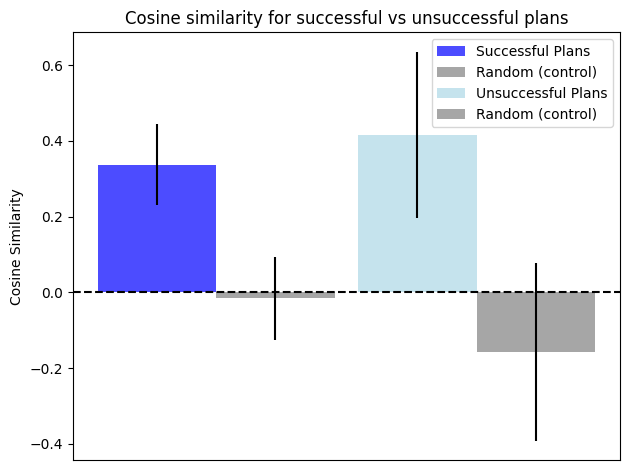

143
145
26
26


In [538]:
# cos sim between plan / move based on if dot was in scope of plan
## use marginal dist of random vectors 

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

AP = np.pi/2
PLAN_SPACE = np.pi/2
MODULES = 9
x = np.linspace(-PLAN_SPACE, PLAN_SPACE, MODULES)
y = np.linspace(-PLAN_SPACE, PLAN_SPACE, MODULES)[::-1]
xv, yv = np.meshgrid(x, y)
random_directions = np.vstack([xv.flatten(), yv.flatten()])

pos_arr_mod = mod_(pos_arr)
pos_plan_arr_mod = mod_(pos_plan_arr)
dot_arr_mod = mod_(dot_arr)

cos_similarities = {
    "successful_actual": [],
    "successful_random": [],
    "unsuccessful_actual": [],
    "unsuccessful_random": []
}

for decision, pos, pos_plan, dot_pos in zip(sample_arr, pos_arr_mod, pos_plan_arr_mod, dot_arr_mod):
    changes = np.diff(np.concatenate([[0], decision, [0]]))
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    
    for start, end in zip(starts, ends):
        plan_traj = pos_plan[end - 1] - pos[start]
        if np.linalg.norm(plan_traj) == 0:
            continue
                
        norm_plan_traj = plan_traj / np.linalg.norm(plan_traj)
        
        # Determine if plan was successful or unsuccessful
        in_scope = any([
            abs(dot_pos[t][0] - pos_plan[t][0]) <= AP or
            abs(dot_pos[t][1] - pos_plan[t][1]) <= AP
            for t in range(start, end)
        ])
        
        # For actual movement
        if end < len(decision) - 1:
            move_dir = pos[end + 1] - pos[end]
            if np.linalg.norm(move_dir) == 0:
                continue
                
            norm_move_dir = move_dir / np.linalg.norm(move_dir)
            cos_sim = np.dot(norm_plan_traj, norm_move_dir)

            # Categorize based on plan success
            if in_scope:
                cos_similarities["successful_actual"].append(cos_sim)
            else:
                cos_similarities["unsuccessful_actual"].append(cos_sim)

        # For random movement
        random_move_dir = random_directions[:,np.random.choice(MODULES**2)]
        if np.linalg.norm(random_move_dir) == 0:
            continue
                
        norm_random_move_dir = random_move_dir / np.linalg.norm(random_move_dir)
        random_cos_sim = np.dot(norm_plan_traj, norm_random_move_dir)
        
        # Categorize based on plan success
        if in_scope:
            cos_similarities["successful_random"].append(random_cos_sim)
        else:
            cos_similarities["unsuccessful_random"].append(random_cos_sim)

# Calculate means and SEMs for plotting
means = [np.mean(cos_similarities[key]) for key in cos_similarities]
sems = [np.std(cos_similarities[key]) / np.sqrt(len(cos_similarities[key])) for key in cos_similarities]

# Print means and their type
print('means=', means)

# Plot
labels = ["Successful Plans", "Random (control)", "Unsuccessful Plans", "Random (control)"]
bar_width = 1
positions = [1, 2, 3.2, 4.2]
bars = plt.bar(positions, means, yerr=1.96*np.array(sems), width=bar_width, color=['blue', 'gray', 'lightblue', 'gray'], alpha=0.7)
for bar, label in zip(bars, labels):
    bar.set_label(label)
plt.axhline(y=0, color='k', linestyle='--')
plt.xticks([])
plt.legend(loc="upper right")
plt.ylabel('Cosine Similarity')
plt.title('Cosine similarity for successful vs unsuccessful plans')
plt.tight_layout()
plt.show()

# Print bin sizes
for key in cos_similarities:
    print(len(cos_similarities[key]))


In [465]:
# means

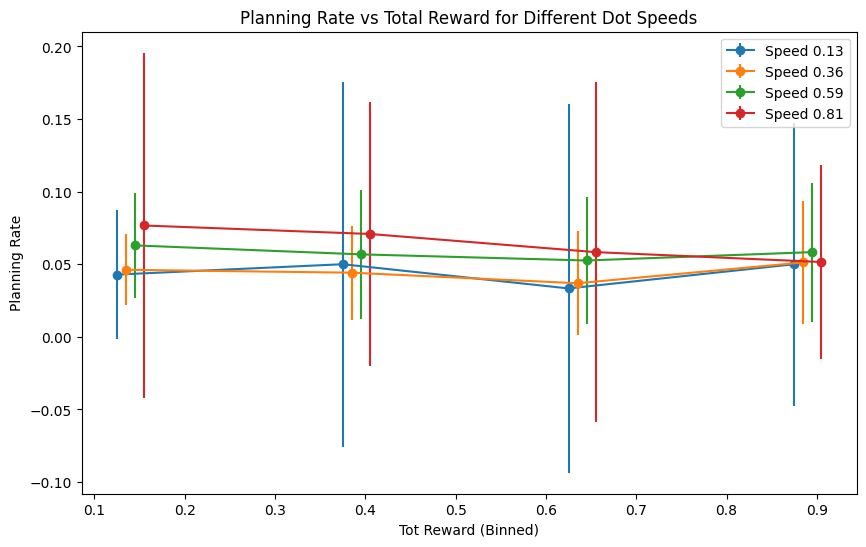

In [455]:
# plan rate vs tot reward, binned for dot speed

import numpy as np
import matplotlib.pyplot as plt

sbins = 4
rbins = 4

# dot speeds
dot_diffs = np.diff(dot_positions, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=sbins + 1)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# reward bins
reward_bins = np.linspace(0, 1, rbins + 1)
reward_bin_centers = (reward_bins[:-1] + reward_bins[1:]) / 2

plt.figure(figsize=(10, 6))

# speed bin
for s in range(len(speed_bins) - 1):
    mask_speed = (mean_dot_speeds >= speed_bins[s]) & (mean_dot_speeds < speed_bins[s + 1])
    
    planning_rates_per_speed = []
    planning_std_per_speed = []

    # reward bin
    for r in range(len(reward_bins) - 1):
        mask_reward = (np.sum(r_arr, axis=1) >= reward_bins[r]) & (np.sum(r_arr, axis=1) < reward_bins[r + 1])
        
        # decisions for both speed and reward conditions
        masked_decisions = sample_arr[mask_speed & mask_reward]
        
        # planning rate for this bin
        rate = np.mean(masked_decisions)
        planning_rates_per_speed.append(rate)
        planning_std_per_speed.append(np.std(masked_decisions)/np.sqrt(len(masked_decisions)))

    plt.errorbar(reward_bin_centers + s*0.01, planning_rates_per_speed, yerr=planning_std_per_speed, linestyle='-', marker='o', label=f"Speed {speed_bin_centers[s]:.2f}")

plt.xlabel('Tot Reward (Binned)')
plt.ylabel('Planning Rate')
plt.title('Planning Rate vs Total Reward for Different Dot Speeds')
plt.legend()
plt.show()


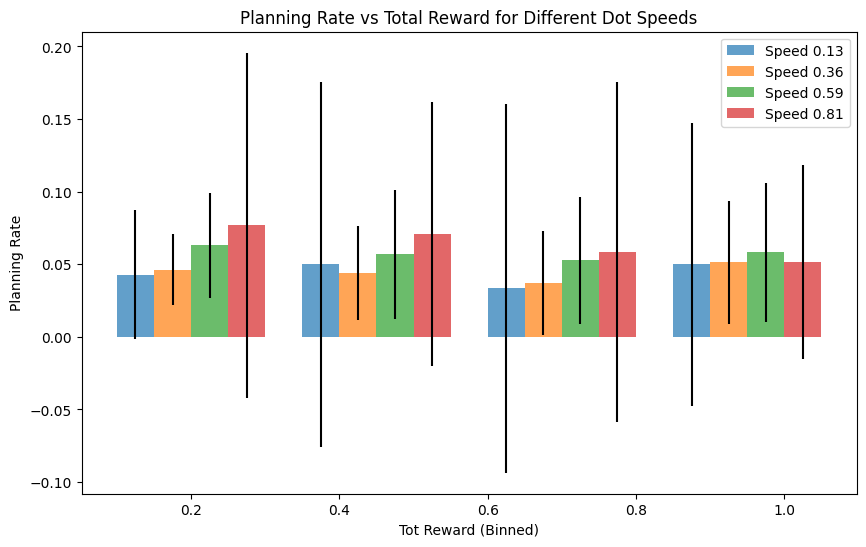

In [460]:
import numpy as np
import matplotlib.pyplot as plt

sbins = 4
rbins = 4

# dot speeds
dot_diffs = np.diff(dot_positions, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=sbins + 1)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# reward bins
reward_bins = np.linspace(0, 1, rbins + 1)
reward_bin_centers = (reward_bins[:-1] + reward_bins[1:]) / 2

plt.figure(figsize=(10, 6))
bar_width = (reward_bins[1] - reward_bins[0]) * 0.2

# speed bin
for s in range(len(speed_bins) - 1):
    mask_speed = (mean_dot_speeds >= speed_bins[s]) & (mean_dot_speeds < speed_bins[s + 1])
    
    planning_rates_per_speed = []
    planning_std_per_speed = []

    # reward bin
    for r in range(len(reward_bins) - 1):
        mask_reward = (np.sum(r_arr, axis=1) >= reward_bins[r]) & (np.sum(r_arr, axis=1) < reward_bins[r + 1])
        
        # decisions for both speed and reward conditions
        masked_decisions = sample_arr[mask_speed & mask_reward]
        
        # planning rate for this bin
        rate = np.mean(masked_decisions)
        planning_rates_per_speed.append(rate)
        planning_std_per_speed.append(np.std(masked_decisions)/np.sqrt(len(masked_decisions)))

    bar_positions = reward_bin_centers + s*bar_width
    plt.bar(bar_positions, planning_rates_per_speed, yerr=planning_std_per_speed, width=bar_width, label=f"Speed {speed_bin_centers[s]:.2f}", alpha=0.7)

plt.xlabel('Tot Reward (Binned)')
plt.ylabel('Planning Rate')
plt.title('Planning Rate vs Total Reward for Different Dot Speeds')
plt.legend()
# plt.xticks([])  # This will remove x ticks
plt.show()


pr= [0.0037735852]
pr= [0.0037735852, 0.023493515]
pr= [0.0037735852, 0.023493515, 0.09184149]
pr= [0.0037735852, 0.023493515, 0.09184149, 0.078260876]
pr= [0.0037735852, 0.023493515, 0.09184149, 0.078260876, 0.14285715]


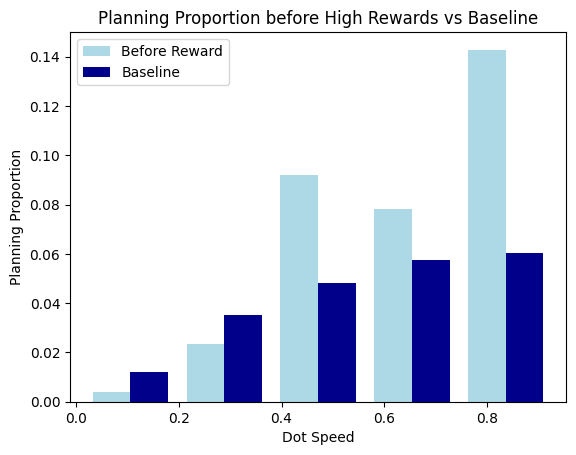

In [497]:
# plan rate before reward

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Constants (adjustable)
PREVIOUS_STEPS = 5
REWARD_THRESHOLD = 0.7
sbins = 5

# Calculate dot speeds (assuming you have dot_positions as before)
dot_diffs = np.diff(dot_positions, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=sbins + 1)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Result containers
plan_ratios = []
baseline_ratios = []

# For each speed bin
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    masked_decisions = sample_arr[mask]
    masked_rewards = r_arr[mask]

    all_plans_before_rewards = []
    for trial_num, (decision, rewards) in enumerate(zip(masked_decisions, masked_rewards)):
        high_reward_indices = np.where(rewards > REWARD_THRESHOLD)[0]
        
        if len(high_reward_indices) == 0:
            # print(f"{trial_num} has no rewards")
            continue

        planning_periods_before_rewards = []
        for idx in high_reward_indices:
            start_idx = max(0, idx-PREVIOUS_STEPS)
            if start_idx >= idx:
                # print(f"Insufficient steps before high reward at index {idx} in trial {trial_num}.")
                continue

            planning_rate = np.mean(decision[start_idx:idx])
            planning_periods_before_rewards.append(planning_rate)

        if not planning_periods_before_rewards:
            # print(f"Trial {trial_num} had high rewards but no valid planning rates were calculated.")
            continue

        all_plans_before_rewards.extend(planning_periods_before_rewards)


    plan_ratios.append(np.mean(all_plans_before_rewards))
    print('pr=',plan_ratios)
    baseline_ratios.append(np.mean(masked_decisions))

# Plot
bar_width = (speed_bins[1] - speed_bins[0]) * 0.4
plt.bar(speed_bin_centers - bar_width/2, plan_ratios, width=bar_width, label="Before Reward", color="lightblue")
plt.bar(speed_bin_centers + bar_width/2, baseline_ratios, width=bar_width, label="Baseline", color="darkblue")
plt.xlabel('Dot Speed')
plt.ylabel('Planning Proportion')
plt.title('Planning Proportion before High Rewards vs Baseline')
plt.legend()
plt.show()


sample_arr.shape= (1000, 80)
pos_arr.shape= (1000, 81, 2)
pos_plan_arr.shape= (1000, 81, 2)


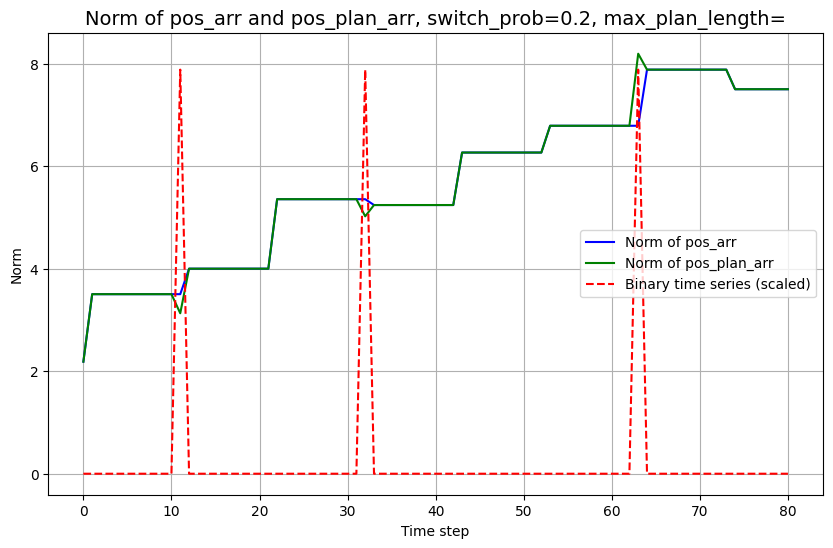

In [345]:
# v2/3, norm of pos_arr and pos_plan_arr:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# plot timeseries, v3
print('sample_arr.shape=',sample_arr.shape)
print('pos_arr.shape=',pos_arr.shape)
print('pos_plan_arr.shape=',pos_plan_arr.shape)

k = 0
binary_array = sample_arr[k,:] # .T, -1
binary_array = jnp.concatenate([jnp.zeros((1,)),binary_array],axis=0)

# Calculate the norms
norm_pos_arr = jnp.linalg.norm(pos_arr[k,:,:], axis=1) # .T
norm_pos_plan_arr = jnp.linalg.norm(pos_plan_arr[k,:,:], axis=1) # .T

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting norms
plt.plot(norm_pos_arr, label="Norm of pos_arr", color='blue')
plt.plot(norm_pos_plan_arr, label="Norm of pos_plan_arr", color='green')

# Plotting binary time series
plt.plot(binary_array * norm_pos_arr.max(), label="Binary time series (scaled)", color='red', linestyle='--')

# Additional plot settings
plt.title(f"Norm of pos_arr and pos_plan_arr, switch_prob={'0.2'}, max_plan_length={''}", fontsize=14)
plt.xlabel("Time step")
plt.ylabel("Norm")
plt.legend()
plt.grid(True)

plt.show()

In [215]:
# binned sort (old)
r_arr_ = r_arr[:10]
sample_arr_ = sample_arr[:10]
dot_arr_ = dot_arr[:10]

# Calculate dot speeds (assuming you have the dot_positions array from previous scripts)
dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
BINS = 6
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=BINS+1)

# Containers for results
sorted_rewards_by_bin = []
sorted_planning_rates_by_bin = []

# Loop through bins
for i in range(BINS):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    masked_decisions = sample_arr[mask]
    masked_rewards = r_arr[mask]
    print('masked_rewards=',masked_rewards.shape)

    # Calculate total reward and planning rate for each trial
    total_rewards = np.sum(masked_rewards,axis=1)
    planning_rates = np.mean(masked_decisions, axis=1)

    # Get the sorted indices in descending order
    reward_indices = np.argsort(total_rewards)[::-1]
    planning_indices = np.argsort(planning_rates)[::-1]
    
    # Store the top 5 indices for rewards and planning rates
    sorted_rewards_by_bin.append(reward_indices[:5])
    sorted_planning_rates_by_bin.append(planning_indices[:5])

# Print top 5 indices for rewards and planning rates in each bin
for i, (reward_indices, plan_indices) in enumerate(zip(sorted_rewards_by_bin, sorted_planning_rates_by_bin)):
    print(f"Bin {i + 1}")
    print(f"Top 5 reward indices: {reward_indices}")
    print(f"Top 5 planning rate indices: {plan_indices}")


masked_rewards= (110, 60)
masked_rewards= (236, 60)
masked_rewards= (267, 60)
masked_rewards= (247, 60)
masked_rewards= (118, 60)
masked_rewards= (21, 60)
Bin 1
Top 5 reward indices: [108  62  15 104  64]
Top 5 planning rate indices: [26 47  6 60 94]
Bin 2
Top 5 reward indices: [101 172 164 216 157]
Top 5 planning rate indices: [ 38 223 169 123 109]
Bin 3
Top 5 reward indices: [246 101 215 239  89]
Top 5 planning rate indices: [166 165 138  60 251]
Bin 4
Top 5 reward indices: [213  84 134 137  74]
Top 5 planning rate indices: [ 41 145  24 224 190]
Bin 5
Top 5 reward indices: [10 13 62 83 97]
Top 5 planning rate indices: [43 64 47 22 42]
Bin 6
Top 5 reward indices: [ 9  1 12 11 17]
Top 5 planning rate indices: [10 19 15 13 17]


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_38098/3485321831.py:86: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_38098/3485321831.py:87: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_38098/3485321831.py:88: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


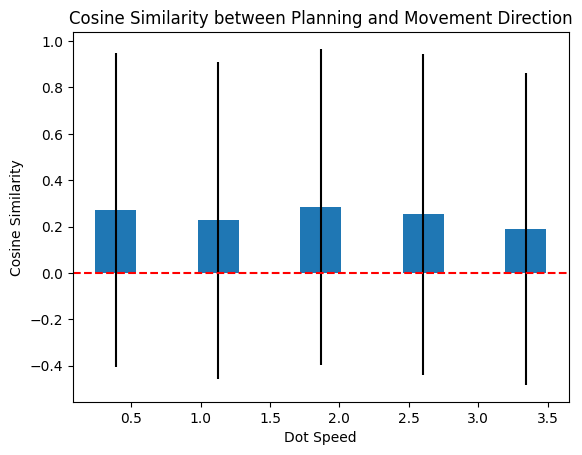

In [153]:
# cos sim plan/next move (OLD)

import numpy as np
import matplotlib.pyplot as plt

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

# Sample Data
dot_arr_mod = mod_(dot_arr) #np.random.rand(1000, 121, 2)
pos_arr_mod = mod_(pos_arr)
pos_plan_arr_mod = mod_(pos_plan_arr)

# Calculate dot speeds
dot_diffs = np.diff(dot_positions, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=6)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Result containers
cos_similarities = []

# For each speed bin
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_decisions = sample_arr[mask]
    masked_pos = pos_arr_mod[mask]
    masked_pos_plan = pos_plan_arr_mod[mask]
    
    similarities = []
    
    # For each trial in the bin
    for decision, pos, pos_plan in zip(masked_decisions, masked_pos, masked_pos_plan):
        # Find the planning periods
        changes = np.diff(np.concatenate([[0], decision, [0]]))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        
        for start, end in zip(starts, ends):
            plan_traj = pos_plan[end - 1] - pos[start]
            
            if np.linalg.norm(plan_traj) == 0:
                continue  # skip if plan_traj is a zero vector, to avoid /0
                
            norm_plan_traj = plan_traj / np.linalg.norm(plan_traj)
            
            if end < len(decision) - 1:  # check if there's a next timestep
                move_dir = pos[end + 1] - pos[end]
                if np.linalg.norm(move_dir) == 0:
                    continue  # skip if move_dir is a zero vector, to avoid /0
                            
                norm_move_dir = move_dir / np.linalg.norm(move_dir)
                cos_sim = np.dot(norm_plan_traj, norm_move_dir)
                similarities.append(cos_sim)
                
    if similarities:  # If there are any valid similarities
        cos_similarities.append((np.mean(similarities), np.std(similarities)))
    else:
        cos_similarities.append((np.nan, np.nan))  # default value if no valid similarities in the bin
        
# Plot
means, stds = zip(*cos_similarities)
bar_width = (speed_bins[1] - speed_bins[0]) * 0.4

plt.bar(speed_bin_centers, means, yerr=stds, width=bar_width)
plt.axhline(y=0, color='r', linestyle='--')  # Replace 0 with your baseline value
plt.xlabel('Dot Speed')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between plan and next move')
plt.show()


In [134]:
# % in scope (old)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

# Data
pos_plan_arr_mod = mod_(pos_plan_arr)
dot_arr_mod = mod_(dot_arr)
AP = np.pi/2

# Calculate dot speeds
dot_diffs = np.diff(dot_arr_mod, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=6)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Result containers
in_scope_ratios = []

# For each speed bin
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_decisions = sample_arr[mask]
    masked_dot = dot_arr_mod[mask] #pos_arr[mask]
    masked_pos_plan = pos_plan_arr_mod[mask]
    
    ratios = []
    
    # For each trial in the bin
    for decision, dot, plan_pos in zip(masked_decisions, masked_dot, masked_pos_plan):
        # Find the planning periods
        changes = np.diff(np.concatenate([[0], decision, [0]]))
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        # print('decision=',decision,'dot_pos=',dot_pos,'plan_pos=',plan_pos)
        # print('changes=',changes,'starts=',starts,'ends=',ends)
        
        for start, end in zip(starts, ends):
            in_scope_count = 0
            for t in range(start, end):
                # Check if dot is "in scope"
                horizontal_dist = np.abs(dot[t][0] - plan_pos[t][0])
                vertical_dist = np.abs(dot[t][1] - plan_pos[t][1])
                print('dot=',dot[t],'plan_pos=',plan_pos[t])
                
                if horizontal_dist <= AP or vertical_dist <= AP:
                    # print('yes')
                    in_scope_count += 1

            
            ratio = in_scope_count / (end - start)
            ratios.append(ratio)
                
    in_scope_ratios.append((np.mean(ratios), np.std(ratios)))

# Plot
means, stds = zip(*in_scope_ratios)
plt.bar(speed_bin_centers, means, yerr=stds, width=speed_bins[1] - speed_bins[0])
plt.xlabel('Dot Speed')
plt.ylabel('Proportion In-Scope')
plt.title('Proportion of plan with dot in-scope')
plt.show()

print('means=',means)

dot= [-1.1156449 -1.450117 ] plan_pos= [ 0.11607385 -0.34359217]
dot= [-1.0944681 -1.3632307] plan_pos= [-0.2766254  0.8345053]
dot= [-0.96740746 -0.841913  ] plan_pos= [-1.4547225   0.44180608]
dot= [-0.94623065 -0.7550266 ] plan_pos= [-0.6693244   0.44180608]
dot= [ 0.02790022 -3.0414412 ] plan_pos= [-2.6328194 -1.5216898]
dot= [ 0.26084447 -2.0856907 ] plan_pos= [-1.8474219 -1.1289909]
dot= [ 2.4238155 -1.918406 ] plan_pos= [0.5396693  0.47322798]
dot= [ 0.30317926 -1.740252  ] plan_pos= [ 1.7177665 -3.0610638]
dot= [ 0.17063951 -1.7291174 ] plan_pos= [ 0.9323685 -2.2756658]
dot= [-0.624599  -1.6623096] plan_pos= [1.3250673 2.436724 ]
dot= [-1.4198372 -1.5955019] plan_pos= [2.5031645 0.865927 ]
dot= [-1.552377  -1.5843673] plan_pos= [2.5031645 2.436724 ]
dot= [-1.4168402  -0.07669353] plan_pos= [-1.0433383 -1.6343565]
dot= [ 1.664839  -1.3937428] plan_pos= [-2.6141343  1.899935 ]
dot= [-2.0571322 -1.9444344] plan_pos= [-0.05384088 -0.26968026]
dot= [ 1.1426051 -0.6254723] plan_pos= 

KeyboardInterrupt: 

plan_periods= [ 0  1  7  8 54 65]
move_after_plan= [0. 0.]
plan_periods= [15 31 32 38 44 45]
move_after_plan= [0. 0.]
plan_periods= [10 46]
move_after_plan= [0. 0.]
plan_periods= [20 36 52 63 69 70]
move_after_plan= [0. 0.]
plan_periods= [ 0 16 17 23 39 40 61 62 68 79]
move_after_plan= [0. 0.]
plan_periods= [15 31 37 43 74]
move_after_plan= [0. 0.]
plan_periods= [ 0  1  7  8 24 65 71 77 78]
move_after_plan= [0. 0.]
plan_periods= [ 0 21 22 28 39 60]
move_after_plan= [0. 0.]
plan_periods= [30 46]
move_after_plan= [0. 0.]
plan_periods= [10 16 22 33 69 70]
move_after_plan= [0. 0.]
plan_periods= [ 0  6 67 68 69]
move_after_plan= [0. 0.]
plan_periods= [10 21 32 38 69 70]
move_after_plan= [0. 0.]
plan_periods= [ 0 11 37 58 59 75]
move_after_plan= [0. 0.]
plan_periods= [10 11 17 48 74]
move_after_plan= [0. 0.]
plan_periods= [25 31 37 78 79]
move_after_plan= [0. 0.]
plan_periods= [10 31 57 68]
move_after_plan= [0. 0.]
plan_periods= [60 76]
move_after_plan= [0. 0.]
plan_periods= [ 5 11 32 53]
mo

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret =

move_after_plan= [0. 0.]
plan_periods= [ 5 11 17 48 54 60]
move_after_plan= [0. 0.]
plan_periods= [ 0  6 12 18 29 30 36 37 48 64 70]
move_after_plan= [0. 0.]
plan_periods= [ 5  6  7  8 19 50 71 77 78 79]
move_after_plan= [0. 0.]
plan_periods= [ 5  6 17 43 44]
move_after_plan= [0. 0.]
plan_periods= [20 26 42 43]
move_after_plan= [0. 0.]
plan_periods= [30 36 37 38 39 40 61 67 73 74]
move_after_plan= [0. 0.]
plan_periods= [15 16 22 23 44 60 71]
move_after_plan= [0. 0.]
plan_periods= [ 5 76]
move_after_plan= [0. 0.]
plan_periods= [10 31 62 63 69]
move_after_plan= [0. 0.]
plan_periods= [ 0  6  7  8 14 15 36 42 63 64 65 71 72]
move_after_plan= [0. 0.]
plan_periods= [ 5 16 22 38 49 75 76 77 78]
move_after_plan= [0. 0.]
plan_periods= [ 5 11 57 63 74 75 76]
move_after_plan= [0. 0.]
plan_periods= [ 5 16 32 33 44 45]
move_after_plan= [0. 0.]
plan_periods= [ 0  1  7  8  9 15 16 27 43 49]
move_after_plan= [0. 0.]
plan_periods= [10 31 42 68]
move_after_plan= [0. 0.]
plan_periods= [10 31 42 53 64 70]

/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


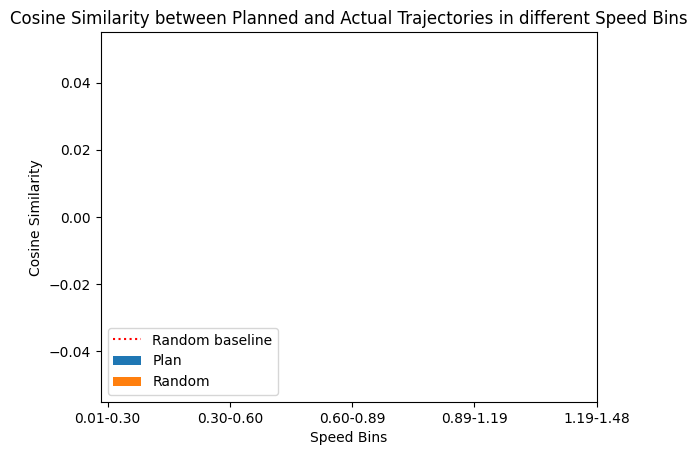

In [136]:
# old vers

import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

bins = 5
ACTION_SPACE = np.pi/2
MODULES = 9

def get_cosine_similarity(a, b):
    return 1 - scipy.spatial.distance.cosine(a, b)

x = jnp.linspace(-ACTION_SPACE,ACTION_SPACE,MODULES) ## (finer resolution)
y = jnp.linspace(-ACTION_SPACE,ACTION_SPACE,MODULES)[::-1]
xv,yv = jnp.meshgrid(x,y)
vectors = jnp.vstack([xv.flatten(),yv.flatten()])

# Calculate dot speeds
dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=bins+1)

# Store cosine similarities
bin_cosine_similarities = []
bin_random_cosine_similarities = []

for i in range(bins):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    masked_samples = sample_arr[mask]
    masked_pos = pos_arr[mask]
    masked_pos_plan = pos_plan_arr[mask]

    cosine_similarities = []
    random_cosine_similarities = []
    
    for trial in range(masked_pos.shape[0]):
        plan_periods = np.where(masked_samples[trial] == 1)[0]
        print('plan_periods=',plan_periods)
        
        if not len(plan_periods): # as long as there _are_ plans
            continue
        
        start_time = plan_periods[0]
        end_time = plan_periods[-1]  # Including the first move after the plan finishes
        
        plan_traj = masked_pos_plan[trial, end_time] - masked_pos[trial, start_time]
        # print('plan_traj=',plan_traj)
        
        # Ensure plan_traj is not a zero vector to avoid division by zero when normalizing
        if np.linalg.norm(plan_traj) == 0:
            continue
        
        plan_traj_normalized = plan_traj / np.linalg.norm(plan_traj)
        # print('plan_traj_normalized=',plan_traj_normalized)
        
        move_after_plan = masked_pos[trial, end_time + 1] - masked_pos[trial, end_time]
        print('move_after_plan=',move_after_plan)
        if np.linalg.norm(move_after_plan) == 0:
            continue
        
        move_after_plan_normalized = move_after_plan / np.linalg.norm(move_after_plan)
        print('move_after_plan_normalized=',move_after_plan_normalized)
        
        cosine_similarity = get_cosine_similarity(plan_traj_normalized, move_after_plan_normalized)
        print('cosine_similarity=',cosine_similarity)

        cosine_similarities.append(cosine_similarity)
        
        # Compare with random plans
        for vector in vectors.T:
            vector_norm = vector / np.linalg.norm(vector)
            random_cosine_similarity = cosine_similarity(plan_traj_normalized, vector_norm)
            random_cosine_similarities.append(random_cosine_similarity)
    
    bin_cosine_similarities.append((np.mean(cosine_similarities), np.std(cosine_similarities)))
    bin_random_cosine_similarities.append((np.mean(random_cosine_similarities), np.std(random_cosine_similarities)))

# Plotting
x = np.arange(len(bin_cosine_similarities))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [mean for mean, std in bin_cosine_similarities], width, label='Plan', yerr=[std for mean, std in bin_cosine_similarities])
rects2 = ax.bar(x + width/2, [mean for mean, std in bin_random_cosine_similarities], width, label='Random', yerr=[std for mean, std in bin_random_cosine_similarities])

ax.axhline(y=np.mean([mean for mean, std in bin_random_cosine_similarities]), color='r', linestyle='dotted', label='Random baseline')
ax.set_xlabel('Speed Bins')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Cosine Similarity between Planned and Actual Trajectories in different Speed Bins')
ax.set_xticks(x)
ax.set_xticklabels([f'{speed_bins[i]:.2f}-{speed_bins[i + 1]:.2f}' for i in range(len(speed_bins) - 1)])
ax.legend()

plt.show()


In [ ]:
# v1 (no plan)

In [ ]:
# load arrs, pgv1
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np

np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def freeze_array(BA, P):
    P2 = np.zeros_like(P)
    P2[:, 0] = P[:, 0]
    for t in range(1, P.shape[1]):
        if BA[t] == 0:
            P2[:, t] = P[:, t]  # Update to current value in P
        else:
            P2[:, t] = P2[:, t - 1]  # Hold previous value
    return P2

# file_ = 'outer_loop_pg_new_v1_ppo__10_09-072009.pkl'

file_ = 'outer_loop_pg_new_v1_ppo_c_init__15_09-082206.pkl' # 'outer_loop_pg_new_v3__11_09-200631.pkl' # 'outer_loop_pg_new_v1__27_08-15_S39.pkl'
# (other,weights_s) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
other = load_data(file_)
(r_arr,rt_arr,pos_arr,dot_arr) = other ##sample_arr (r_arr,rt_arr,pos_arr,dot_arr)
print('r_arr.shape=',r_arr.shape,'rt_arr.shape=',rt_arr.shape,'pos_plan_arr.shape=',pos_plan_arr.shape,'dot_arr.shape=',dot_arr.shape) #,'sample_arr.shape=',sample_arr.shape)
# print('weights_s["Us_f"].shape=',weights_s["Us_f"].shape)

# pos_arr = np.zeros_like(pos_plan_arr)
# for i in range(pos_plan_arr.shape[0]):
#     pos_arr[i,:,:] = freeze_array(sample_arr[i,:].T,pos_plan_arr[i,:,:]) # pm_arr[]
# print('pos_arr.shape=',pos_arr.shape)

print('pos_arr=',pos_arr[0,:,:])

In [ ]:
# sort arrs, pgv1/2/3
tot_reward = jnp.sum(r_arr, axis=1)
r_tot_desc = jnp.argsort(tot_reward)[::-1]
r_tot_asc = jnp.argsort(tot_reward) #[::-1]
# tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
# loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
# loss_v_desc = jnp.argsort(tot_loss_v)[::-1]
# tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
# loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('r_tot_desc=',r_tot_desc[:10])
print('r_tot_asc=',r_tot_asc[:10])
# print('loss_v_asc=',loss_v_asc[:10])
# print('loss_v_desc=',loss_v_desc[:10])
# print('loss_d_asc=',loss_d_asc[:10])

In [490]:
avg_noplan_rewards = [13.62,3.05,0.93,0.72]
std_noplan_rewards = [7.33,4.76,1.77,1.33]
avg_noplan_rewards = np.array(avg_noplan_rewards)
std_noplan_rewards = np.array(std_noplan_rewards)
avg_shuffle_rewards = [10.50,1.05,0.49,0.43]
std_shuffle_rewards = [13.55,4.77,1.12,0.75]
avg_shuffle_rewards = np.array(avg_shuffle_rewards)
std_shuffle_rewards = np.array(std_shuffle_rewards)


In [ ]:
# full ani pgv1 wip
%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    # get x/y coords
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    # weighted complex numbers
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    # mean
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    # weighted circular variance for each angle
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    # v_pred_vec = np.clip(v_pred_vec,0,None)
    # v_pred_norm = v_pred_vec/np.sum(v_pred_vec)
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    # mean_magnitude = (np.exp(kappa_x+kappa_y)/((2*np.pi)**2 * scipy.special.i0(kappa_x) * scipy.special.i0(kappa_y)))
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,r_arr,dot_arr,pos_arr,dot,agent,aperture_points,act_space_points,plan_space_points,L):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    # dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')

    # x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i],np.pi)### think
    # x_y_coords,x,y,mean_x_ap,mean_y_ap,sigma_x_ap,sigma_y_ap = circ_mean_var(v_pred_arr[i],np.pi)### think
    # scale = APERTURE/jnp.pi
    # ell_circular.set_center((mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1])))
    # ell_circular.width = SIGMA_SCALE*sigma_x
    # ell_circular.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_pred.set_center((mean_x, mean_y))
    # ell_circular_v_pred.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_pred.height = SIGMA_SCALE*sigma_y
    # ell_circular_v_t.set_center((mean_x, mean_y))
    # ell_circular_v_t.width = SIGMA_SCALE*sigma_x
    # ell_circular_v_t.height = SIGMA_SCALE*sigma_y
    # if i>0:
        # in_ell_array[i] = is_point_in_ellipse(mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1]), mod_(dot_arr[i,0]), mod_(dot_arr[i,1]), SIGMA_SCALE*sigma_x, SIGMA_SCALE*sigma_y)
        # kappa_x,loc_x,kappa_y,loc_y,mean_magnitude = vonmises_fit(x_y_coords[0,:],x_y_coords[1,:],v_pred_arr[i])
        # text_ani.set_label(f'Frame {i}/{STEPS}, reward={mean_magnitude:.3f}')    
        # ax_ani.get_legend().remove()
        # ax_ani.legend(loc='right') #, bbox_to_anchor=(1, 1))
        # text_ani.set_text(f'vm_fit_mean={mean_magnitude}') # mod_(loc_x+pos_arr[i, 0])},{mod_(loc_y+pos_arr[i, 1])
        # print('i=',i,'mean_ell=',mod_(mean_x+pos_arr[i, 0]),mod_(mean_y+pos_arr[i, 1]),'mean_vm=',mod_(loc_x+pos_arr[i, 0]),mod_(loc_y+pos_arr[i, 1]),'mean_magnitude_vm=',mean_magnitude)
    lab = f'Frame={i}, Reward={r_arr[i]:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
    L.get_texts()[0].set_text(lab)

    # print('pos=',pos_arr[i,:],'mean=',mean_x,mean_y,'sigma=',sigma_x,sigma_y,'in_ell=',in_ell_array[i])

    # scatters_pred.set_offsets(neuron_locs.T)
    # scatters_pred.set_array(v_pred_arr[i])
    # scatters_pred.set_sizes(15 * np.sqrt(v_pred_arr[i])) # []
    # scatters_pred.set_facecolors('k')

    # scatters_t.set_offsets(neuron_locs.T)
    # scatters_t.set_array(v_t_arr[i])
    # scatters_t.set_sizes(15 * np.sqrt(v_t_arr[i])) # []
    # scatters_t.set_facecolors('k')
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    x_aperture_centre,y_aperture_centre = get_aperture_points(np.array([0,0]),APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    # aperture_points_v_pred.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    # aperture_points_v_t.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_DEFAULT)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    x_plan_space,y_plan_space = get_aperture_points(pos_arr[i],PLAN_SPACE,DENSITY_PLAN_SPACE)
    plan_space_points.set_offsets(np.c_[mod_(x_plan_space), mod_(y_plan_space)])
    
    return [dot,agent,aperture_points,act_space_points,plan_space_points,L]

k = 1022 # 0,202, 275
interval = 300
APERTURE = (1/2)*np.pi # (3/5)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1/2 
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 2 #3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = pos_arr.shape[1]
MODULES = 7 # 7 # 9 # 17 # 15
# NEURONS_DISP = np.int32(np.sqrt(v_pred_arr.shape[2])) ##14 # 16 # 15 # 15 # 12 # 6 # ''full'' np.int32(NEURONS_AP*(np.pi//APERTURE))
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_PLAN_SPACE = 10

# neuron_locs = gen_vectors(NEURONS_DISP,jnp.pi) # NEURONS
# v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1)
# v_t_arr_ = v_t_arr[k,:,:]
r_arr_ = r_arr[k,:]
dot_arr_ = dot_arr[k,:,:] # [STEPS,2]
pos_arr_ = pos_arr[k,:,:] # [STEPS,2]
# rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
# dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')
# dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)
plan_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

# ell_circular = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ell_circular_patch = ax_ani.add_patch(ell_circular)
# text_ani = ax_ani.text(0.5, 0.8, '', transform=ax_ani.transAxes)
# ax_ani.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax_ani.legend(loc='upper right')
L=ax_ani.legend(loc='upper right')

# in_ell_array = np.zeros(STEPS,)

# ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# # update scatter
# scatters_pred = ax_pred.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_pred_arr_[0], 
#     s=15 * np.sqrt(v_pred_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)
# aperture_points_v_pred = ax_pred.scatter([], [], color='black', s=0.5)
# ell_circular_v_pred = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_pred = ax_pred.add_patch(ell_circular_v_pred)
# set_axis_properties(ax_pred, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_pred')

# ax_t = plt.subplot(gs[2, 1], aspect='equal')
# # update scatter
# scatters_t = ax_t.scatter(
#     neuron_locs[0, :], neuron_locs[1, :], 
#     c='k', # v_t_arr_[0], 
#     s=15 * np.sqrt(v_t_arr_[0]), 
#     marker='o',
#     vmin=0, vmax=1)  # Assuming activations range from 0 to 1
# aperture_points_v_t = ax_t.scatter([], [], color='black', s=0.5)
# ell_circular_v_t = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
# ecp_v_t = ax_t.add_patch(ell_circular_v_t)
# set_axis_properties(ax_t, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_t')

partial_animate = functools.partial(
    animate,
    # v_pred_arr=v_pred_arr_, 
    # v_t_arr=v_t_arr_, 
    r_arr=r_arr_,
    dot_arr=dot_arr_, 
    # dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    # dot_hat=dot_hat,
    agent=agent, 
    # neuron_locs=neuron_locs, 
    # scatters_pred=scatters_pred, 
    # scatters_t=scatters_t,
    aperture_points=aperture_points,
    # aperture_points_v_pred=aperture_points_v_pred,
    # aperture_points_v_t=aperture_points_v_t,
    act_space_points=act_space_points,
    plan_space_points=plan_space_points,
    # ell_circular=ell_circular,
    # ell_circular_v_pred=ell_circular_v_pred,
    # ell_circular_v_t=ell_circular_v_t,
    # in_ell_array=in_ell_array,
    # text_ani=text_ani,
    # ax_ani=ax_ani,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

# print('in_ell_array=',in_ell_array[1:])
# print(r'% in array = ',np.sum(in_ell_array[1:])/(STEPS-1))